# GPN-MSA: basic example

## Setup

In [1]:
#!pip install --quiet git+https://github.com/songlab-cal/gpn.git

In [2]:
from gpn.data import GenomeMSA, Tokenizer
import gpn.model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
from transformers import AutoModel, AutoModelForMaskedLM

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_path = "songlab/gpn-msa-sapiens"
# see README in https://huggingface.co/datasets/songlab/multiz100way for faster queries
msa_path = "zip:///::https://huggingface.co/datasets/songlab/multiz100way/resolve/main/89.zarr.zip"

## Loading data

Example region: chr6:31575665-31575793

[UCSC Genome Browser view](https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr6%3A31575665%2D31575793&hgsid=1726885238_vIMnX2NGEluaKCXVZjeTkj97aydM) 

In [4]:
genome_msa = GenomeMSA(msa_path)  # can take a minute or two

In [5]:
# untokenized msa
raw_msa = genome_msa.get_msa("6", 31575665, 31575793, strand="+", tokenize=False)
print(raw_msa.shape)
raw_msa

(128, 90)


array([[b'A', b'A', b'-', ..., b'-', b'-', b'-'],
       [b'C', b'G', b'-', ..., b'-', b'-', b'-'],
       [b'A', b'A', b'A', ..., b'-', b'-', b'-'],
       ...,
       [b'T', b'T', b'T', ..., b'-', b'-', b'-'],
       [b'C', b'T', b'C', ..., b'-', b'-', b'-'],
       [b'C', b'C', b'C', ..., b'-', b'-', b'-']], dtype='|S1')

In [6]:
# tokenized msa
msa = genome_msa.get_msa("6", 31575665, 31575793, strand="+", tokenize=True)
msa

array([[1, 1, 0, ..., 0, 0, 0],
       [2, 3, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [4, 4, 4, ..., 0, 0, 0],
       [2, 4, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0]], dtype=uint8)

In [7]:
msa = torch.tensor(np.expand_dims(msa, 0).astype(np.int64))
msa

tensor([[[1, 1, 0,  ..., 0, 0, 0],
         [2, 3, 0,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [4, 4, 4,  ..., 0, 0, 0],
         [2, 4, 2,  ..., 0, 0, 0],
         [2, 2, 2,  ..., 0, 0, 0]]])

In [8]:
# separating human from rest of species
input_ids, aux_features = msa[:, :, 0], msa[:, :, 1:]
input_ids.shape, aux_features.shape

(torch.Size([1, 128]), torch.Size([1, 128, 89]))

## Embedding

In [9]:
model = AutoModel.from_pretrained(model_path)
model.eval();

Some weights of the model checkpoint at songlab/gpn-msa-sapiens were not used when initializing GPNRoFormerModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing GPNRoFormerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPNRoFormerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
with torch.no_grad():
    embedding = model(input_ids=input_ids, aux_features=aux_features).last_hidden_state
embedding.shape

torch.Size([1, 128, 768])

In [11]:
# Let's do a quick visualization. We'll standardize the embeddings.
embedding_df = pd.DataFrame(StandardScaler().fit_transform(embedding[0].numpy()))
embedding_df.index.name = "Position"
embedding_df.columns.name = "Embedding dimension"
embedding_df

Embedding dimension,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
Position,,,,,,,,,,,,,,,,,,,,,
0,-0.793460,0.605153,-1.583886,-0.542659,-1.312394,0.493330,-0.353474,0.889004,-0.649606,-0.368195,...,1.472854,0.091098,-0.044150,0.813585,1.267370,0.341651,0.256661,-2.196030,0.179917,0.220744
1,0.593601,-0.345529,0.447001,0.218888,-0.319071,0.721635,0.667857,-0.586375,0.121319,0.573092,...,0.747436,-0.199769,-1.047910,0.476114,-0.828803,-0.970284,-0.667071,-0.703088,-0.165467,0.493727
2,-0.287573,0.913004,-1.375024,-0.653606,-1.249884,0.062281,-0.632157,1.216259,-0.618074,-0.606616,...,0.902706,0.194269,-0.285796,0.801168,0.702376,-0.502150,0.179040,-1.586547,0.321579,1.016936
3,-0.847065,0.914218,-1.428794,-0.253545,-1.153859,0.515371,-0.489298,1.223763,-0.216737,-0.232051,...,1.674459,-0.623742,0.094558,1.107732,1.287710,0.625728,0.148599,-1.693072,0.085577,-0.342404
4,0.174905,-0.964661,-0.470735,0.883543,-0.313751,1.130918,-0.846813,1.395477,-0.662498,0.256760,...,-0.064593,-0.527352,0.662073,-0.547796,-0.570136,1.161361,-1.459216,-0.531189,0.866101,0.279880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,-0.350832,-1.474939,-1.129313,0.438186,-0.554595,0.567339,-0.633881,0.826359,-0.997829,1.520874,...,-0.161489,-0.107504,1.147247,-1.364775,2.233690,-0.422305,-0.227845,3.326982,0.565312,-0.470890
124,-0.472841,0.958609,1.900296,-0.493118,-0.504176,-1.182258,2.055996,-1.383483,2.800460,-0.995337,...,1.192350,0.014169,0.670027,0.044374,1.375447,-0.186231,1.467670,0.651576,-1.963656,0.484896
125,-2.126083,-0.877145,-0.273190,-1.046106,3.342416,-0.535338,-0.684740,-0.866756,-1.770838,-0.774816,...,0.176887,1.544010,-0.064719,-0.380002,2.564108,0.028088,2.056381,0.267000,0.420038,-2.260433


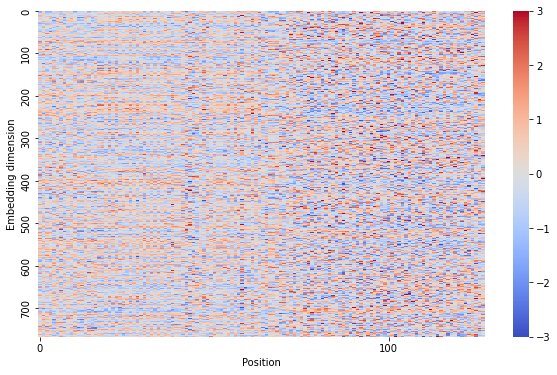

In [12]:
# hard to see much, there seem to be differences between 5' UTR and CDS though
plt.figure(figsize=(10, 6))
sns.heatmap(embedding_df.T, center=0, vmin=-3, vmax=3, cmap="coolwarm", square=False, xticklabels=100, yticklabels=100);

## Masked language modeling

In [13]:
model_for_mlm = AutoModelForMaskedLM.from_pretrained(model_path)
model_for_mlm.eval();

In [14]:
raw_msa[76:79, 0]  # Start codon

array([b'A', b'T', b'G'], dtype='|S1')

In [15]:
tokenizer = Tokenizer()
pos = 76  # Let's mask the A and check the model predictions
input_ids[0, pos] = tokenizer.mask_token_id()

In [16]:
input_ids
with torch.no_grad():
    all_logits = model_for_mlm(input_ids=input_ids, aux_features=aux_features).logits
all_logits.shape

torch.Size([1, 128, 6])

In [17]:
nucleotides = list('ACGT')
logits = all_logits[0, pos, [tokenizer.vocab.index(nc) for nc in nucleotides]]
logits

tensor([ 6.0621, -1.5262, -0.6878, -0.5625])

In [18]:
probs = torch.nn.functional.softmax(logits, dim=0).numpy()
probs

array([9.9700433e-01, 5.0483737e-04, 1.1674578e-03, 1.3233320e-03],
      dtype=float32)

<Axes: xlabel='nucleotide', ylabel='probability'>

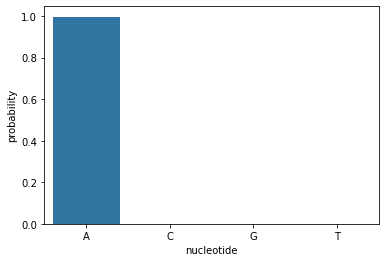

In [19]:
probs_df = pd.DataFrame(dict(nucleotide=nucleotides, probability=probs))
sns.barplot(data=probs_df, x="nucleotide", y="probability")